In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [32]:
import numpy as np
import pylab as plt

import opticspy

from utils import midPoint
from parabolas import fitLeicaScan, newParabola
from simulateSignal import zernikePoly
from lassiAnalysis import maskLeicaData, regridXYZ

In [3]:
n = 512
file1 = '/home/scratch/psalas/LASSI/gpu_smoothing/Scan-9.full.copy.ptx.csv'
file2 = '/home/scratch/psalas/LASSI/gpu_smoothing/Scan-11.full.copy.ptx.csv'

In [19]:
ref_data = maskLeicaData(file1, n=n)
sig_data = maskLeicaData(file2, n=n)

In [20]:
xr, yr, zr = ref_data['origMasked']
dzr = ref_data['fitResidual']
xpr, ypr, zpr = ref_data['parabolaFit']
xrr, yrr, zrr = ref_data['rotated']
cr = ref_data['parabolaFitCoeffs']

xs, ys, zs = sig_data['origMasked']
dzs = sig_data['fitResidual']
xps, yps, zps = sig_data['parabolaFit']
xrs, yrs, zrs = sig_data['rotated']
cs = sig_data['parabolaFitCoeffs']

In [26]:
print(cr - cs)

[-1.29241845e-02 -2.38755020e-03 -3.93167766e-03  3.28560930e-06
  0.00000000e+00  1.24344979e-14]


In [30]:
xmin = np.min([np.nanmin(xrr), np.nanmin(xrs)])
xmax = np.min([np.nanmax(xrr), np.nanmax(xrs)])
ymin = np.min([np.nanmin(yrr), np.nanmin(yrs)])
ymax = np.min([np.nanmax(yrr), np.nanmax(yrs)])

xgr, ygr, zpgr = regridXYZ(xrr, yrr, zpr, n=512., verbose=False, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xgs, ygs, zpgs = regridXYZ(xrs, yrs, zps, n=512., verbose=False, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

<IPython.core.display.Javascript object>


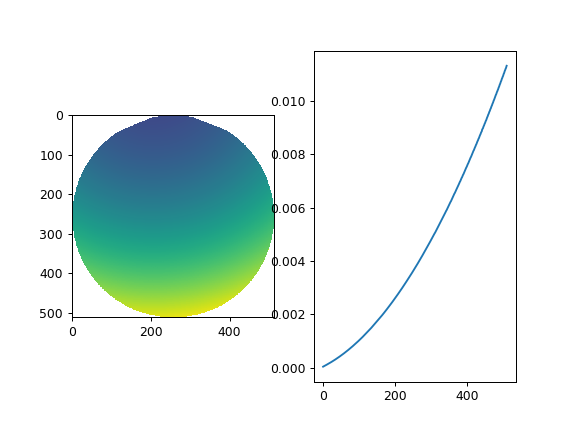

In [52]:
plt.figure()

plt.subplot(121)
plt.imshow(zpgr - zpgs)

plt.subplot(122)
plt.plot((zpgr - zpgs)[:,250])

<IPython.core.display.Javascript object>


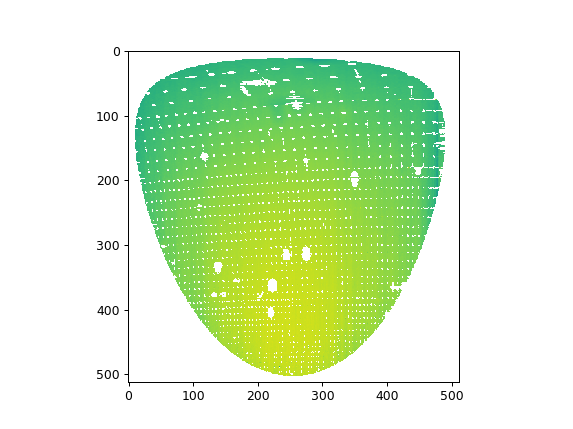

<IPython.core.display.Javascript object>


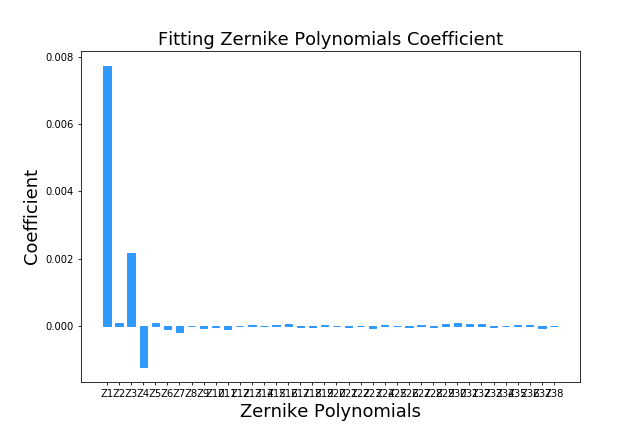

In [59]:
newXr, newYr, newZr = newParabola(xr, yr, zr, cr[0], cr[1], cr[2], cr[3], cr[4], cr[5])
newXs, newYs, newZs = newParabola(xs, ys, zs, cs[0], cs[1], cs[2], cs[3], cr[4]*(1 - 0.0001), cr[5])
newZr.shape = (n,n)
newZs.shape = (n,n)
dzr_ = zr - newZr
dzs_ = zs - newZs
diff_ = np.ma.masked_where(zs.mask, dzs_) - np.ma.masked_where(zr.mask, dzr_)
plt.figure()
plt.imshow(np.log10(abs(diff_)))

x,y,rdiff = regridXYZ(xs.filled(np.nan), 
                      ys.filled(np.nan), 
                      diff_.filled(np.nan), 
                      n=n, verbose=False)
_,_,rmask = regridXYZ(xs.filled(np.nan), 
                      ys.filled(np.nan), 
                      np.ma.masked_where(xs.mask, diff_.mask.astype(float)).filled(np.nan), 
                      n=n, verbose=False)
rdiff = np.ma.masked_where(rmask, rdiff)

fitlist, coeff = opticspy.zernike.fitting(rdiff.filled(0), #rdiff.filled(rdiff.std()), 
                                          38, remain2D=0, barchart=1,
                                          printreport=0)

In [40]:
diff1 = dzr #np.ma.masked_where(zs1.mask, diff1)
diff2 = dzs #np.ma.masked_where(zs2.mask, diff2)

In [41]:
diff = np.ma.masked_invalid(diff1 - diff2)

<IPython.core.display.Javascript object>


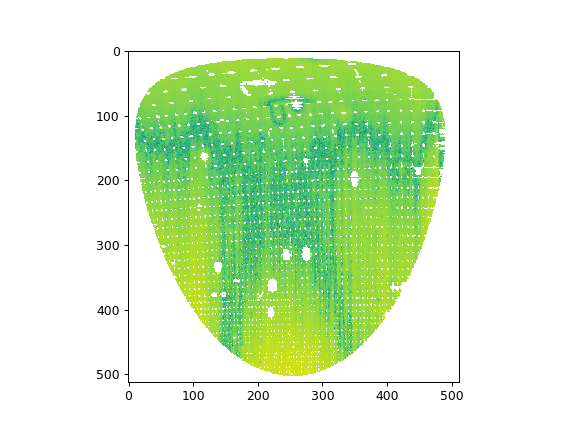

In [42]:
plt.figure()

plt.imshow(np.log10(abs(diff)))

In [10]:
mask = (((xs - 2)**2 + (ys - 50)**2) <= 45**2)
xs_ = np.ma.masked_where(~mask, xs)
ys_ = np.ma.masked_where(~mask, ys)
diff_ = np.ma.masked_where(~mask, diff)

In [11]:
x,y,rdiff = regridXYZ(xs_.filled(np.nan), 
                      ys_.filled(np.nan), 
                      diff_.filled(np.nan), 
                      n=n, verbose=False)

In [12]:
_,_,rmask = regridXYZ(xs_.filled(np.nan), 
                      ys_.filled(np.nan), 
                      np.ma.masked_where(xs_.mask, diff_.mask.astype(float)).filled(np.nan), 
                      n=n, verbose=False)
rdiff = np.ma.masked_where(rmask, rdiff)

<IPython.core.display.Javascript object>


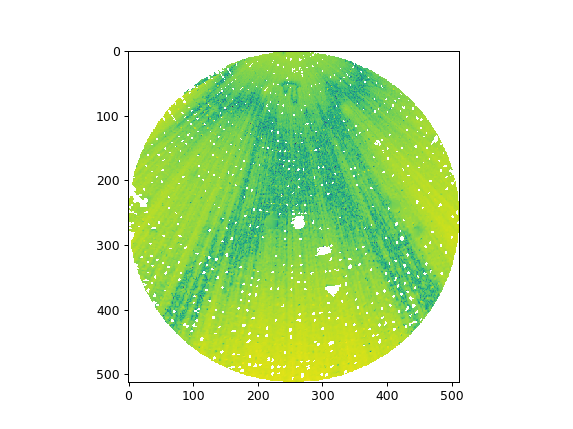

In [13]:
plt.figure()
plt.imshow(np.log10(abs(rdiff)))

<IPython.core.display.Javascript object>


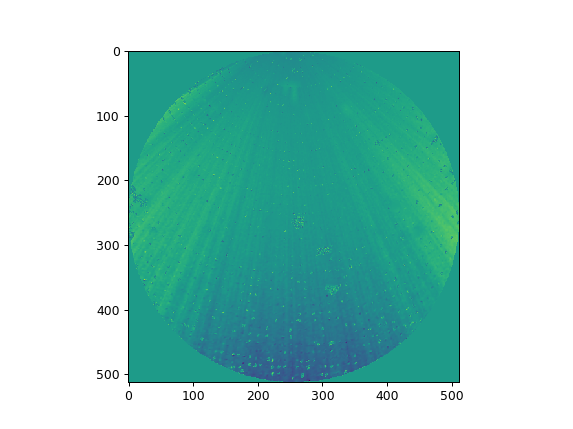

In [14]:
rdiff_mask = rdiff.mask
fill = np.random.normal(0, rdiff.std(), rdiff_mask.sum())
rdiff_filled = np.copy(rdiff)
rdiff_filled[rdiff_mask] = fill
rdiff_filled.shape = (n,n)
cmask = (((x - 2)**2 + (y - 50)**2) <= 45**2)
rdiff_filled = np.ma.masked_where(~cmask, rdiff_filled)

plt.figure()

plt.imshow(rdiff_filled.filled(0))

<IPython.core.display.Javascript object>


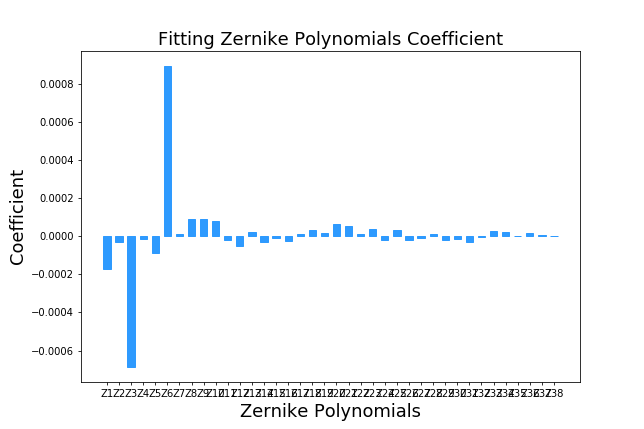

CPU times: user 34.7 s, sys: 75 ms, total: 34.7 s
Wall time: 34.7 s


In [15]:
%%time
fitlist, coeff = opticspy.zernike.fitting(rdiff_filled.filled(0), #rdiff.filled(rdiff.std()), 
                                          38, remain2D=0, barchart=1,
                                          printreport=0)

In [27]:
expected = np.zeros(38)
expected[5] = 1.7

<IPython.core.display.Javascript object>


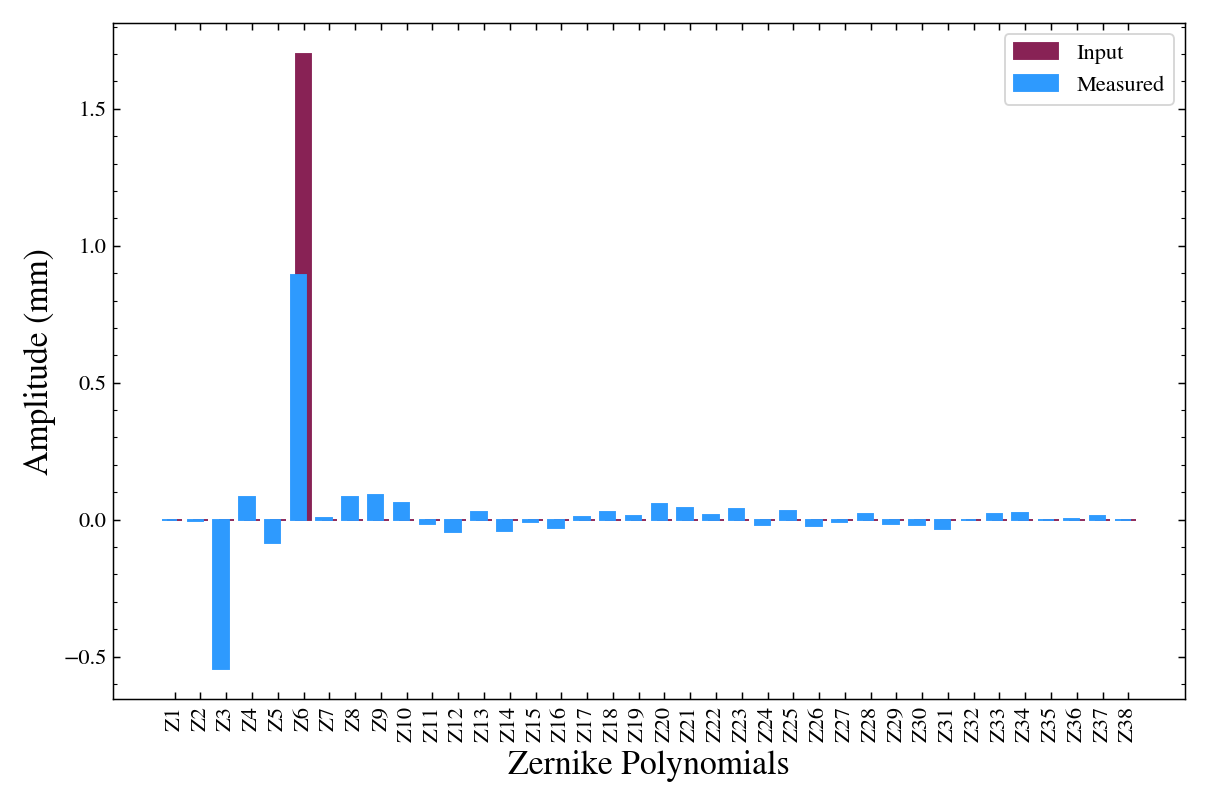

In [30]:
import matplotlib
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

# Plot the results
fitlist1 = np.array(fitlist[0:38])
index = np.arange(38)

fig = plt.figure(figsize=(9, 6), dpi=150)
ax = fig.add_subplot(111)
xticklist = []
width = 0.6
for i in index:
    xticklist.append('Z'+str(i+1))
    
plt.bar(index, expected, width, color='#882255', edgecolor='#882255', label='Input')
plt.bar(index-0.2, fitlist1*1000., width, color='#2E9AFE', edgecolor='#2E9AFE', label='Measured')
plt.xticks(index+width//2, xticklist, rotation=90)
plt.xlabel('Zernike Polynomials',fontsize=18)
plt.ylabel('Amplitude (mm)',fontsize=18)
plt.legend(loc=0, fancybox=True)
#plt.title('Fitting Zernike Polynomials Coefficient',fontsize=18)
ax.minorticks_on()
ax.tick_params('both', direction='in', top=True, right=True)
ax.tick_params('y', which='minor', direction='in', left=True, right=True)
ax.tick_params('x', which='minor', bottom=False)

plt.tight_layout()
plt.show()
plt.savefig('Mar27_Z6.png',
            bbox_inches='tight',
            pad_inches=0.06)

<IPython.core.display.Javascript object>


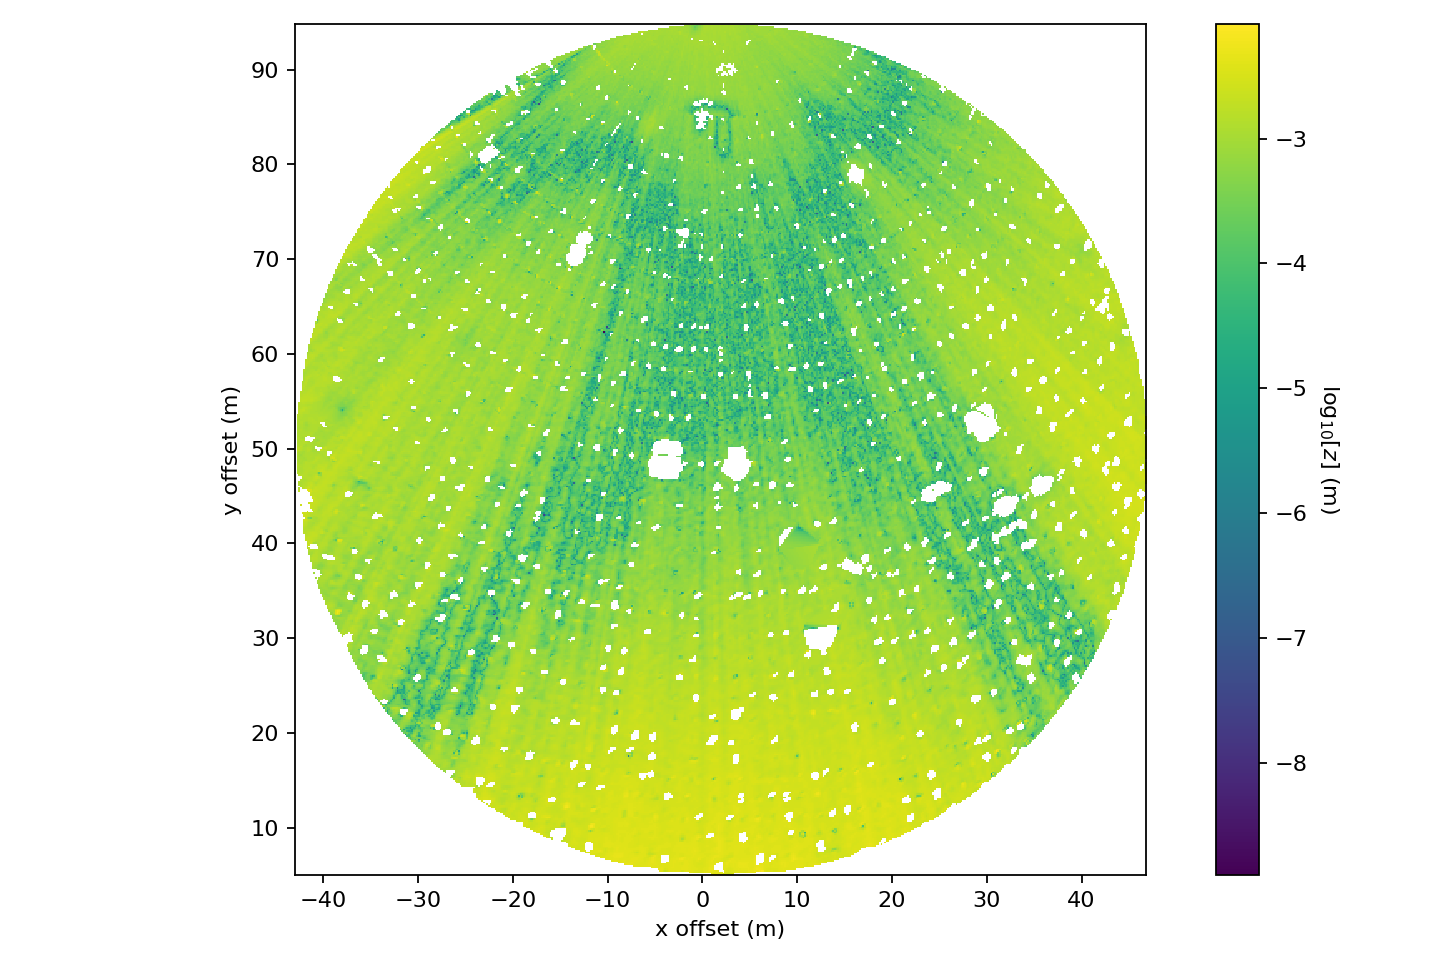

In [69]:
fig = plt.figure(figsize=(9, 6), dpi=180)
ax = fig.add_subplot(111)

extent = [x.min(), x.max(), y.min(), y.max()]

im = ax.imshow(np.log10(abs(rdiff)), extent=extent)

cbar = plt.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\log_{10}[z]$ (m)', rotation=270)

ax.set_xlabel('x offset (m)')
ax.set_ylabel('y offset (m)')

plt.tight_layout()
plt.savefig('Jun6_diff.pdf',
            bbox_inches='tight',
            pad_inches=0.06)

In [23]:
# Subtract the fitted Zernike from the observed surface
xmid = midPoint(xs1)
ymid = midPoint(ys1)
print("Midpoint: {} , {}".format(xmid, ymid))
fitlist_ = fitlist
z_fit = zernikePoly(xs1, ys1, xmid, ymid, amplitude=fitlist_)
z_fit = np.ma.masked_invalid(z_fit)
_, _, z_fit_s = regridXYZ(xs1.filled(np.nan), 
                          ys1.filled(np.nan), 
                          z_fit.filled(np.nan), 
                          n=n, verbose=False)
z_fit_s = np.ma.masked_invalid(z_fit_s)

Midpoint: 2.0018558502197266 , 49.9904146194458
Zernike polynomials with amplitudes [0, -4.448106034527234e-06, -0.000544014640673841, 8.130800060877814e-05, -8.413764799061677e-05, 0.0008948519182807439, 4.721484637179653e-06, 8.177797854214408e-05, 8.89738158526599e-05, 6.257685717792677e-05, -1.5637073298561065e-05, -4.476789989605716e-05, 2.799966896911795e-05, -4.016475112791891e-05, -7.1633702180475356e-06, -2.9855259656731562e-05, 8.3758914695959e-06, 2.8360972691866708e-05, 1.2088078751499967e-05, 5.870042826838307e-05, 4.425609773919383e-05, 1.6886546468739133e-05, 4.028456934520059e-05, -1.861272980361501e-05, 3.0125617552234045e-05, -2.13752945829085e-05, -8.309238045616296e-06, 2.037041864675911e-05, -1.4797406605269346e-05, -1.9476180681227244e-05, -3.5352111593653375e-05, -1.1625746263738983e-06, 2.0228979902888985e-05, 2.3043218463489835e-05, -2.3436431311105693e-06, 1.5776083842817696e-06, 1.2313502517103103e-05, 0.0]
Their linear combination has mean: 2.10e-05, min: -3

<IPython.core.display.Javascript object>


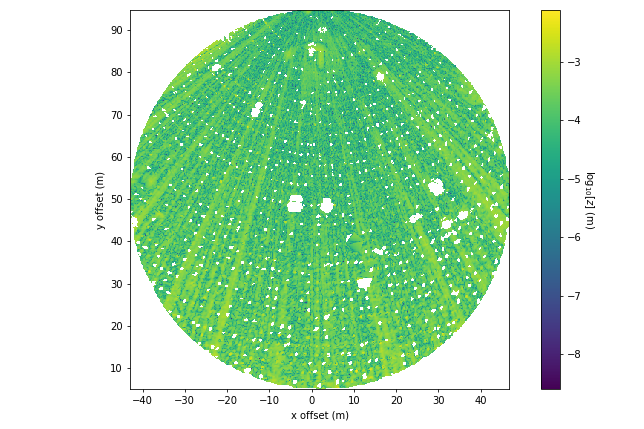

In [223]:
fig = plt.figure(figsize=(9, 6), dpi=80)
ax = fig.add_subplot(111)

extent = [x.min(), x.max(), y.min(), y.max()]

im = ax.imshow(np.log10(abs(rdiff - z_fit_s)), extent=extent)

cbar = plt.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\log_{10}[z]$ (m)', rotation=270)

ax.set_xlabel('x offset (m)')
ax.set_ylabel('y offset (m)')

plt.tight_layout()
#plt.savefig('Jun6_diff_res.pdf',
#            bbox_inches='tight',
#            pad_inches=0.06)

In [221]:
print(rdiff.std())
print((rdiff - z_fit_s[::1]).std())

0.001174674870839534
0.0003079071641135002


<IPython.core.display.Javascript object>


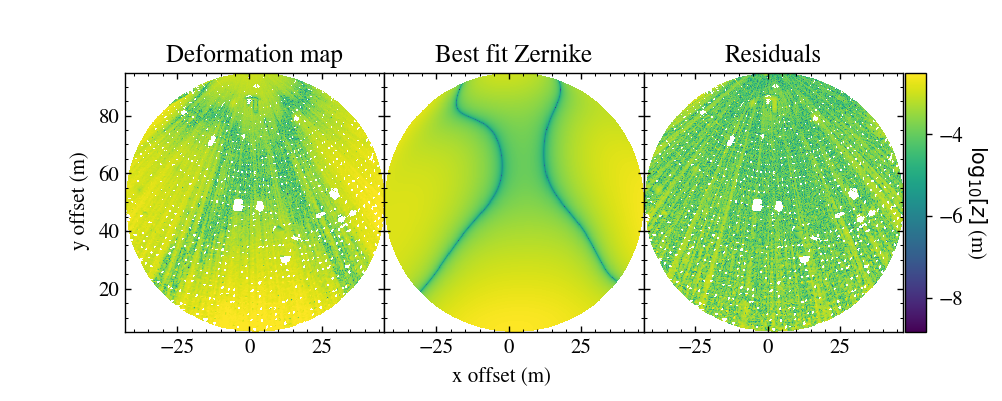

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

extent = [x.min(), x.max(), y.min(), y.max()]
vmin = np.min([np.log10(abs(rdiff)), 
               np.log10(abs(z_fit_s[::1,::1])), 
               np.log10(abs(rdiff - z_fit_s[::1,::1]))])
vmax = np.max([np.log10(abs(rdiff)), 
               np.log10(abs(z_fit_s[::1,::1])), 
               np.log10(abs(rdiff - z_fit_s[::1,::1]))])
vmax = -2.5
fig = plt.figure(figsize=(8.,3.2), dpi=140)
plt.subplots_adjust(hspace=0., wspace=0.)

fig.text(0.5, 0.05, "x offset (m)", ha='center')
fig.text(0.07, 0.5, "y offset (m)", va='center', rotation='vertical')

ax1 = fig.add_subplot(131)
ax1.set_title('Deformation map')
im = ax1.imshow(np.log10(abs(rdiff)), extent=extent, vmin=vmin, vmax=vmax)
ax1.minorticks_on()
ax1.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)

ax2 = fig.add_subplot(132)
ax2.set_title('Best fit Zernike')
im = ax2.imshow(np.log10(abs(z_fit_s[::1,::1])), extent=extent, vmin=vmin, vmax=vmax)
ax2.set_yticklabels([])
ax2.minorticks_on()
ax2.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)

ax3 = fig.add_subplot(133)
ax3.set_title('Residuals')
im = ax3.imshow(np.log10(abs(rdiff - z_fit_s[::1,::1])), extent=extent, vmin=vmin, vmax=vmax)
ax3.set_yticklabels([])
ax3.minorticks_on()
ax3.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)

cax = inset_axes(ax3, width='8%', height='100%',
                loc=3, bbox_to_anchor=(1.01, 0, 1, 1),
                bbox_transform=ax3.transAxes,
                borderpad=0.)

cbar = plt.colorbar(im, cax=cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\log_{10}[z]$ (m)', rotation=270)

#fig.set_tight_layout({'pad':10})
#plt.tight_layout()
plt.savefig('Mar27_Z6_map.png',
            bbox_inches='tight',
            pad_inches=0.06)

In [279]:
plt.subplots_adjust?